In [1]:
#removing warnings
import warnings
warnings.simplefilter('ignore')

# Import Libraries Required.
# pydata stack
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#plotting library
import altair as alt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
 # enabling sklearn's experimental gradient boosting machine algorithm
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# others
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from plot_decision_regions import plot_decision_regions
from sklearn.metrics import roc_curve, auc

from sklearn.base import BaseEstimator, TransformerMixin


from statsmodels.stats.outliers_influence import variance_inflation_factor

# custom functions
from cleaning import read_clean_data, impute_data
from tables import classification_report

# set random seed
random_state= 1
np.random.seed(random_state)

In [6]:
data = pd.read_csv('data.csv')

In [3]:
#recoding high cardinality features

# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'
data['cnt_child'] = data.CNT_CHILDREN.apply(cnt_child).astype('category')

# reducing family count feature to 4 categories
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'
data['cnt_family'] = data.CNT_FAM_MEMBERS.apply(cnt_family).astype('category')

# reducing engineered feature CREDIT_ACTIVE to 4 categories
data.CREDIT_ACTIVE = data.CREDIT_ACTIVE.astype(np.uint32)

def credit_active(series):
    if series == 0:
        return 'No Accounts'
    elif 1 <= series <= 3:
        return '1-3 Accounts'
    else : 
        return ' > 4 Accounts'
data['credit_active'] = data.CREDIT_ACTIVE.apply(credit_active).astype('category')

# reducing engineered feature LOAN_COUNT to 5 categories

def loan_count(series):
    if series == 0:
        return 'No Loans'
    elif 1 <= series <= 2:
        return '1-2 Loans'
    elif 3 <= series <= 5:
        return '3-5 Loans'
    elif 6 <= series <= 10:
        return '6-10 Loans'
    else : 
        return ' > 10 Loans'

data['loan_cnt'] = data.LOAN_COUNT.apply(loan_count).astype('category')

In [4]:
#   variables that were deemed the least useful for analysis
new_df = data.copy().drop(['TARGET', 'SK_ID_CURR', 'AMT_GOODS_PRICE', 'CNT_CHILDREN',
                          'CNT_FAM_MEMBERS', 'EXT_SOURCE_1_AV','EXT_SOURCE_2_AV', 'EXT_SOURCE_3_AV', 'LOAN_COUNT',
                          'CREDIT_ACTIVE'], axis = 1)

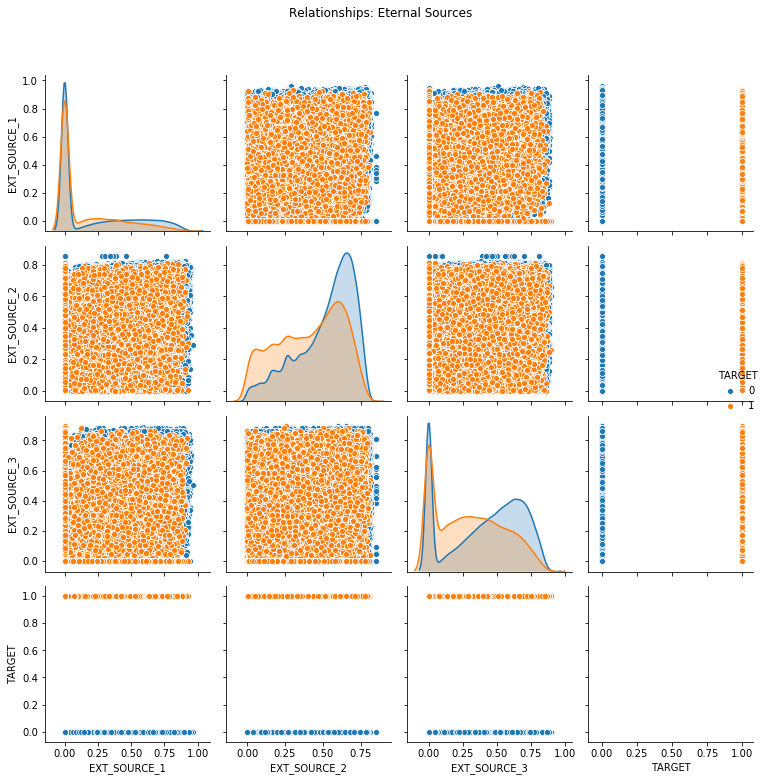

In [8]:
cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
g = sns.pairplot(data[cols], hue = 'TARGET')
g.fig.suptitle('Relationships: Eternal Sources', y= 1.08)
plt.tight_layout()
plt.show()

In [2]:
from cleaning import read_clean_data
data = read_clean_data()

In [3]:
data.shape

(307511, 80)

In [13]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
# Combining numerical features
grp = bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
data_bureau = data.merge(grp, on='SK_ID_CURR', how='left')
data_bureau.update(data_bureau[grp.columns].fillna(0))
# Combining categorical features
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
data_bureau = data_bureau.merge(grp, on='SK_ID_CURR', how='left')
data_bureau.update(data_bureau[grp.columns].fillna(0))
# Shape of application and bureau data combined
print('The shape application and bureau data combined:',data_bureau.shape)

The shape application and bureau data combined: (307511, 115)


In [15]:
# Number of past loans per customer
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
data_bureau = data_bureau.merge(grp, on='SK_ID_CURR', how='left')
data_bureau['BUREAU_LOAN_COUNT'] = data_bureau['BUREAU_LOAN_COUNT'].fillna(0)
# Number of types of past loans per customer 
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
data_bureau = data_bureau.merge(grp, on='SK_ID_CURR', how='left')
data_bureau['BUREAU_LOAN_TYPES'] = data_bureau['BUREAU_LOAN_TYPES'].fillna(0)
# Debt over credit ratio 
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
data_bureau = data_bureau.merge(grp1, on='SK_ID_CURR', how='left')
data_bureau['DEBT_CREDIT_RATIO'] = data_bureau['DEBT_CREDIT_RATIO'].fillna(0)
data_bureau['DEBT_CREDIT_RATIO'] = data_bureau.replace([np.inf, -np.inf], 0)
data_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(data_bureau['DEBT_CREDIT_RATIO'], downcast='float')
# Overdue over debt ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
data_bureau =data_bureau.merge(grp1, on='SK_ID_CURR', how='left')
data_bureau['OVERDUE_DEBT_RATIO'] = data_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
data_bureau['OVERDUE_DEBT_RATIO'] = data_bureau.replace([np.inf, -np.inf], 0)
data_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(data_bureau['OVERDUE_DEBT_RATIO'], downcast='float')

In [16]:
data_bureau.shape

(307511, 119)

In [17]:
previous_application = pd.read_csv('previous_application.csv')
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Number of previous applications per customer
grp = previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
data_bureau_prev = data_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
data_bureau_prev['PREV_APP_COUNT'] = data_bureau_prev['PREV_APP_COUNT'].fillna(0)
# Combining numerical features
grp = previous_application.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
data_bureau_prev = data_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
prev_categorical = pd.get_dummies(previous_application.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_application['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
data_bureau_prev = data_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))

In [19]:
data_bureau_prev.shape

(307511, 282)

In [20]:
pos_cash = pd.read_csv('POS_CASH_balance.csv')
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [21]:
# Combining numerical features
grp = pos_cash.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
data_bureau_prev = data_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
pos_cash_categorical = pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
data_bureau_prev = data_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))

In [22]:
data_bureau_prev.shape

(307511, 296)

In [23]:
installments = pd.read_csv('installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [24]:
# Combining numerical features and there are no categorical features in this dataset
grp = installments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
data_bureau_prev = data_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))

In [25]:
data_bureau_prev.shape

(307511, 302)

In [28]:
credit_card = pd.read_csv('credit_card_balance.csv')
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [29]:
# Combining numerical features
grp = credit_card.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
data_bureau_prev = data_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
credit_categorical = pd.get_dummies(credit_card.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card['SK_ID_CURR']
grp = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
data_bureau_prev = data_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
data_bureau_prev.update(data_bureau_prev[grp.columns].fillna(0))

KeyError: "['CREDIT_AMT_DRAWINGS_OTHER_CURRENT', 'CREDIT_CNT_DRAWINGS_OTHER_CURRENT', 'CREDIT_AMT_RECIVABLE', 'CREDIT_CNT_DRAWINGS_POS_CURRENT', 'CREDIT_AMT_BALANCE', 'CREDIT_AMT_PAYMENT_CURRENT', 'CREDIT_AMT_INST_MIN_REGULARITY', 'CREDIT_MONTHS_BALANCE', 'CREDIT_SK_DPD_DEF', 'CREDIT_CNT_INSTALMENT_MATURE_CUM', 'CREDIT_AMT_RECEIVABLE_PRINCIPAL', 'CREDIT_AMT_TOTAL_RECEIVABLE', 'CREDIT_SK_DPD', 'CREDIT_AMT_DRAWINGS_ATM_CURRENT', 'CREDIT_AMT_PAYMENT_TOTAL_CURRENT', 'CREDIT_CNT_DRAWINGS_ATM_CURRENT', 'CREDIT_AMT_DRAWINGS_POS_CURRENT', 'CREDIT_AMT_DRAWINGS_CURRENT', 'CREDIT_AMT_CREDIT_LIMIT_ACTUAL', 'CREDIT_CNT_DRAWINGS_CURRENT'] not in index"

In [ ]:
data_bureau_prev.shape

In [ ]:
y2    data_bureau_prev.TARGET
y2[y2.isnull()      True]

In [ ]:
random_state = 1

defaults = data_bureau_prev.query('TARGET == 1')
nominal = data_bureau_prev.query('TARGET == 0').sample(n = np.round(0.5 * (defaults.TARGET.size / 0.5)).astype(int),
                                                  random_state = random_state)
# join dataframes and shuffle
downsampled = pd.concat([defaults, nominal]).sample(frac = 1, 
                                                    random_state = random_state)

In [ ]:
downsampled.TARGET.describe()

In [ ]:
# reducing the child count feature to 3 categories
def cnt_child(series):
    if series == 0 :
        return 'No Children'
    elif 1 <= series < 5 :
        return '1-4 Children'
    else :
        return '5 or More Children'
    
# reducing family count feature to 4 categories    
def cnt_family(series):
    if series == 1:
        return '1 Family Member'
    elif series == 2: 
        return '2 Family Members'
    elif 3 >= series <= 5:
        return '3 - -5 Family Members'
    else :
        return '6 or more Family Members'
    
downsampled['cnt_child'] = data.CNT_CHILDREN.apply(cnt_child).astype('object')
downsampled['cnt_family'] = data.CNT_FAM_MEMBERS.apply(cnt_family).astype('object')
y = downsampled.TARGET
downsampled.shape

In [28]:
downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49650 entries, 288063 to 5081
Columns: 331 entries, SK_ID_CURR to cnt_family
dtypes: float32(2), float64(266), int32(1), int64(37), object(14), uint16(10), uint32(1)
memory usage: 122.2+ MB


In [30]:
#downsampled = downsampled.drop(labels = ['TARGET'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(downsampled.drop(['SK_ID_CURR',
                                                                     'EXT_SOURCE_1_AV',
                                                                     'EXT_SOURCE_2_AV',
                                                                     'EXT_SOURCE_3_AV',
                                                                      'AMT_GOODS_PRICE'],axis=1), y, stratify = y, test_size=0.2, random_state=random_state)

X_train = X_train.drop(labels = ['TARGET'], axis = 1)

X_test = X_test.drop(labels = ['TARGET'], axis = 1)
print('Shape of X_train: ', X_train.shape)
print('\nShape of X_test: ', X_test.shape)
print('\nShape of y_train: ', y_train.shape)
print('\nShape of y_test: ', y_test.shape)

Shape of X_train:  (39720, 328)

Shape of X_test:  (9930, 328)

Shape of y_train:  (39720,)

Shape of y_test:  (9930,)


In [36]:
# Separation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]

# imputing missing numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
#refitting an transforming the test set
X_test_num = imputer_num.fit_transform(X_test[num_cols])

#scaling numeric train and test sets seperately
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
#refitting and scaling the test set
X_test_num1 = scaler_num.fit_transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)

In [37]:
print('train: ', X_train_num_final.shape)
print('test: ', X_test_num_final.shape)

train:  (39720, 314)
test:  (9930, 314)


In [38]:
# imputing missing categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
#refitting and imputing test set
X_test_cat = imputer_cat.fit_transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)

In [39]:
print(list(X_train_cat1.columns))

['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EMPLOYED', 'cnt_child', 'cnt_family']


In [40]:
# target encoding on training set
X_train_final = pd.concat([X_train_num_final,X_train_cat1], axis = 1)

# define function that encodes categorical variables by their mean EXT_SOURCE_2 value
def source_2_encode(df):
    types = np.array([dt for dt in df.dtypes])
    all_columns = df.columns.values
    num = types != 'object'
    cat_cols = all_columns[~num]
    for col in df[cat_cols]:
        df[col] = df[col].map(df.groupby(col)['EXT_SOURCE_2'].mean())
    return df
X_train_encode = source_2_encode(X_train_final)

In [41]:
# target encoding on test set
X_test_final= pd.concat([X_test_num_final,X_test_cat1], axis = 1)

X_test_encode = source_2_encode(X_test_final)

In [42]:
print('train: ', X_train_encode.shape)
print('test: ', X_test_encode.shape)
print('\nShape of y_train: ', y_train.shape)
print('\nShape of y_test: ', y_test.shape)

train:  (39720, 328)
test:  (9930, 328)

Shape of y_train:  (39720,)

Shape of y_test:  (9930,)


In [43]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_csv('X_train_final.csv')

X_test_final.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_test.txt', y_test)

In [ ]:

model_sk    lgb.LGBMClassifier(boosting_type  'gbdt', max_depth  7, learning_rate  0.01, n_estimators   2000, 
                 class_weight  'balanced', subsample  0.9, colsample_bytree   0.8, n_jobs  -1)
train_features, valid_features, train_y, valid_y    train_test_split(X_train_final, y_train, test_size    0.15, random_state    42)
model_sk.fit(train_features, train_y, early_stopping_rounds  100, eval_set    [(valid_features, valid_y)], eval_metric    'auc', verbose    200)

In [47]:
clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = 1).fit(X_train_encode, y_train)

# using it on test set
y_pred = clf.predict(X_test_encode)
results = confusion_matrix(y_test, y_pred)

accuracy = (results[0][0] + results[1][1])/(len(y_pred))
precision = results[1][1]/(results[0][1] + results[1][1])
recall = results[1][1]/ (results[1][0] + results[1][1])

print(results,
      '\nAccuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

[[3417 1548]
 [1332 3633]] 
Accuracy: 0.7099697885196374 
Precision: 0.7012159814707586 
Recall: 0.7317220543806646


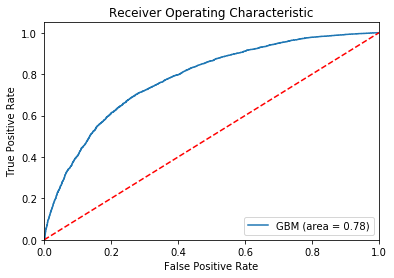

In [48]:
# Compute ROC curve and AUC

fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under the curve


fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_encode)[:,1])
roc_auc = auc(fpr,tpr)

#plotting
plt.figure()
plt.plot(fpr, tpr, label= 'GBM (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

In [51]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0):
        """Iteratively calculate VIF and drop features with highest VIF until
        all VIF values are below the threshold value (`thresh`).
        
        Adapted from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
        """
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [52]:
#    on enlarged dataset

transformer = ReduceVIF()
X = transformer.fit_transform(X_train_final)


ReduceVIF fit
ReduceVIF transform
Dropping BUREAU_CREDIT_ACTIVE_Active with vif=inf
Dropping BUREAU_CREDIT_CURRENCY_currency 1 with vif=inf
Dropping DEBT_CREDIT_RATIO with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Cash loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Consumer loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_Revolving loans with vif=inf
Dropping PREV_NAME_CONTRACT_TYPE_XNA with vif=inf
Dropping PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY with vif=inf
Dropping PREV_FLAG_LAST_APPL_PER_CONTRACT_N with vif=inf
Dropping PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex with vif=inf
Dropping PREV_NAME_CASH_LOAN_PURPOSE_XAP with vif=inf
Dropping PREV_NAME_CONTRACT_STATUS_Approved with vif=inf
Dropping PREV_NAME_CONTRACT_STATUS_Unused offer with vif=inf
Dropping PREV_NAME_PAYMENT_TYPE_Cash through the bank with vif=inf
Dropping PREV_CODE_REJECT_REASON_CLIENT with vif=inf
Dropping PREV_NAME_CLIENT_TYPE_New with vif=inf
Dropping PREV_NAME_GOODS_CATEGORY_Additional Service 

Due to the high importance of EXT_SOURCE_2 in the current application, it could be valuable to estimate what EXT_SOURCE_2 might have been on a previous application. We will use linear regression to predict the value of EXT_SOURCE_2 using data from the current application. We will then  use that model to impute the missing EXT_SOURCE_2 values and create a new feature using the previous application data and test the importance of the predicted value of EXT_SOURCE_2 based on the data from the previous application dataset.

In [57]:
X.shape

(39720, 252)

In [59]:
X_test_vif = X_test_final[list(X.columns)]

In [60]:
clf = HistGradientBoostingClassifier(l2_regularization= 0, 
                                     learning_rate= 0.1,
                                     loss= 'binary_crossentropy',
                                     max_iter= 100,
                                     max_leaf_nodes= 41,
                                     min_samples_leaf= 20,
                                     random_state = 1).fit(X, y_train)

# using it on test set
y_pred = clf.predict(X_test_vif)
results = confusion_matrix(y_test, y_pred)

accuracy = (results[0][0] + results[1][1])/(len(y_pred))
precision = results[1][1]/(results[0][1] + results[1][1])
recall = results[1][1]/ (results[1][0] + results[1][1])

print(results,
      '\nAccuracy: ' + str(accuracy),
      '\nPrecision: ' + str(precision),
      '\nRecall: ' + str(recall))

[[3323 1642]
 [1251 3714]] 
Accuracy: 0.7086606243705942 
Precision: 0.693427931292009 
Recall: 0.748036253776435


In [428]:
# using a Gradient Decent function from Python Machine Learning

class LinearRegressionGD(object):
    # eta is an effective size metric
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta  =  eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        #create matrix to hold weights, with 1 extra row for the intercept
        self.w_ = np.zeros(1 + X.shape[1])
        # list of costs
        self.cost_ = []
        # gradient descent
        for i in range(self.n_iter):
            # grab the dot product of X and the weight matrix
            output = self.net_input(X)
            # distance measurement between training and prediction for each round
            errors = (y - output)
            #new weights are created by multipling the dot product of X^T(errors) by eta (learning rate)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            # cost function (sum of squared errors)/2
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    #getting the dot product of X with weights
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return self.net_input(X)
# pulling remaining columns from X training set


# dropping variables that aren't collinear with EXT_SOURCE_2
app_curr = data.copy().drop(labels = ['EXT_SOURCE_1', 'EXT_SOURCE_3'], axis =1)

# using previously defined important features
source_2_features = [col for col in list(app_curr.columns) if col in list(X.columns) ]
# might need to add TARGET
source_2 = app_curr[source_2_features]

In [429]:
# get rid of na vlaues in CREDIT_LENGTH
source_2 = pd.concat([source_2, data.TARGET], axis = 1).fillna(0)
source_2 = pd.get_dummies(source_2, drop_first = True)

In [430]:
y_s2 = source_2.EXT_SOURCE_2

s2_train, s2_test, ys2_train, ys2_test = train_test_split(source_2.drop(labels = ['EXT_SOURCE_2'], axis =1), y_s2, test_size = 0.2, random_state = random_state)

In [402]:
#w_ = np.zeros(1 + s2_train.shape[1])
output = np.dot(s2_train, w_[1:]) + w_[0]
errors = (ys2_train-output)
# eta = .001
w_ = eta * s2_train.T.dot(errors)
#w_.shape

(168,)

In [406]:
output = np.dot(s2_train, w_[1:]) + w_[0]
output[:50]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
errors = (ys2_train - output)
errors[:50]

In [411]:
eta = .001
#w_[1:] += eta * s2_train.T.dot(errors)
w_[0] += eta * errors.sum()
print(w_[:10], w_[0])

[ 1.26260154e+02  1.39634712e+00  5.24098431e+00  1.20586887e+01
  1.86901188e+01  8.42741564e+00  5.51597432e+00  4.85965323e+00
 -1.11803061e-01  5.09122838e-01] 126.26015415080049


In [413]:
cost = (errors**2).sum() / 2.0
cost

36950.034144003235

In [378]:
print('s2_train: ', s2_train.shape,
      '\n ys2_train : ', ys2_train.shape,
     '\n s2_test : ', s2_test.shape,
     '\n ys2_test: ', ys2_test.shape)

s2_train:  (246008, 167) 
 ys2_train :  (246008,) 
 s2_test :  (61503, 167) 
 ys2_test:  (61503,)


In [ ]:
s2_train[:1,:167].shape

In [431]:
def scale_and_dummies(train_df, test_df):
    scaler = StandardScaler()
    #training set
    types = np.array([dt for dt in train_df.dtypes])
    all_columns = train_df.columns.values
    is_num = types != 'object'
    num_cols = all_columns[is_num]
    cat_cols = all_columns[~is_num]
    if len(cat_cols) == 0:
        train_df = scaler.fit_transform(train_df)
        return train_df
    else:
        nums = scaler.fit_transform(train_df[num_cols])
        train_df = pd.get_dummies(train_df[cat_cols], drop_first = True)       
        train_df = pd.concat([train_df, nums], axis = 1)
    return train_df
    # test set same procedure, --> no fit_transform
    types = np.array([dt for dt in test_df.dtypes])
    all_columns = test_df.columns.values
    is_num = types != 'object'
    num_cols = all_columns[is_num]
    cat_cols = all_columns[~is_num]
    if len(cat_cols) == 0:
        test_df = scaler.fit_transform(test_df)
        return test_df
    else:
        nums = scaler.fit_transform(test_df[num_cols])
        test_df = pd.get_dummies(test_df[cat_cols], drop_first = True)       
        test_df = pd.concat([test_df, nums], axis = 1)
    return test_df
        



s2_train, s2_test = scale_and_dummies(s2_train, s2_test)
#ys2_train = scaler.fit_transform(ys2_train[:, np.newaxis]).flatten()

#s2_test = scale_and_dummies(s2_test, retrain = False)

print('s2_train: ', s2_train.shape,
      '\n ys2_train : ', ys2_train.shape,
     '\n s2_test : ', s2_test.shape,
     '\n ys2_test: ', ys2_test.shape)

ValueError: too many values to unpack (expected 2)

In [415]:
lm = LinearRegressionGD()

lm.fit(s2_train, ys2_train)

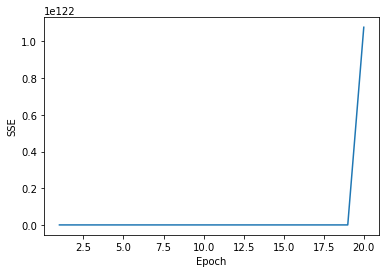

In [416]:
# visualize convergence
plt.plot(range(1, lm.n_iter+1), lm.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [417]:
lm.cost_

[36950.034144003235,
 2154939291.3741612,
 199979554260720.56,
 6.177697005821243e+19,
 7.87021374121213e+25,
 1.7645870537723326e+32,
 4.46425879277342e+38,
 1.1536730065091639e+45,
 2.9921516432272722e+51,
 7.765158707070607e+57,
 2.0154048013825668e+64,
 5.230966619836435e+70,
 1.3576972062361746e+77,
 3.523904456502502e+83,
 9.14629835092027e+89,
 2.3739228978785525e+96,
 6.161519910551308e+102,
 1.599223279700291e+109,
 4.150786065221962e+115,
 1.077337053441033e+122]

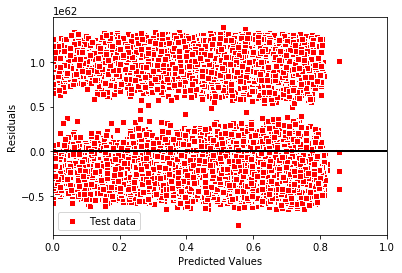

In [418]:
#predict on test set
y_pred = lm.predict(s2_test)
#predict on training set
y_pred_train = lm.predict(s2_train)
# visualize residual plot
def resids(real, predicted):
    
    plt.scatter(real, predicted - real,
                c = 'red', marker = 's', edgecolor = 'white',
                label = 'Test data')
#     plt.scatter(ys2_train, (y_pred_train - ys2_train),
#                 c = 'steelblue', marker = 'o', edgecolor = 'white',
#                label='Train data')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='bottom right')
    plt.hlines(y = 0, xmin = 0, xmax = 1, color = 'black', lw = 2)
    plt.xlim([0, 1])
    plt.show()

resids(ys2_test, y_pred)

In [425]:
print('MSE: ', ((ys2_test - y_pred)**2).mean())

MSE:  2.2835697103064052e+123


In [419]:
#mse
print('MSE training: ', ((y_pred_train - ys2_train)**2).mean())
print('MSE test: ', ((y_pred - ys2_test)**2).mean())

# r^2
from sklearn.metrics import r2_score

print('R^2 train: %.3f, test: %.3f' %
     (r2_score(ys2_train, y_pred_train),
     r2_score(ys2_test, y_pred)))


MSE training:  2.2732835504375027e+123
MSE test:  2.2835697103064052e+123
R^2 train: -61463596252161417154719807071483895775102316321271458773575189109025744904790316781213438590340223075202893421883136283770880.000, test: -61688877076194666796431364145353066775578321710531759791975843392568308991369194723551968519892335217711433559986728790392832.000


In [420]:
# comparing to sklearn SGD Regressor
from sklearn.linear_model import SGDRegressor
# getting function as close to the home-made version as possible
sgdlm = SGDRegressor(random_state = random_state, eta0 = .001, learning_rate = 'constant', max_iter = 20)
sgdlm.fit(s2_train, ys2_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.001, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=20,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=1,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

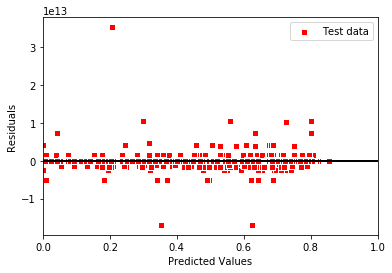

None 
MSE :  5.817746412493432e+22


In [424]:
sgdlm_preds = sgdlm.predict(s2_test)
print(resids(ys2_test, sgdlm_preds), '\nMSE : ', ((ys2_test - sgdlm_preds)**2).mean())

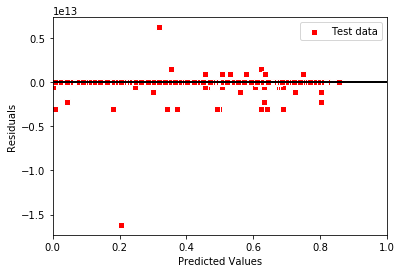

None 
MSE :  6.919482473081235e+21


In [426]:
sgdlm = SGDRegressor(random_state = random_state)
sgdlm.fit(s2_train, ys2_train)
sgdlm_preds = sgdlm.predict(s2_test)
print(resids(ys2_test, sgdlm_preds), '\nMSE : ', ((ys2_test - sgdlm_preds)**2).mean())

In [361]:
from sklearn.linear_model import LinearRegression
sklm = LinearRegression()
sklm.fit(s2_train, ys2_train)

sklm_pred = sklm.predict(s2_test)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(sklm, s2_train, ys2_train, cv=5)
#print('MSE training: ', ((y_pred_train - ys2_train)**2).mean())
print('MSE test: ', ((sklm_pred - ys2_test)**2).mean(),
      "CV scores : ", scores)

MSE test:  0.030482669564850205 CV scores :  [ 1.73306863e-01  1.75364826e-01 -1.39715504e+22  1.74475666e-01
  1.76411381e-01]


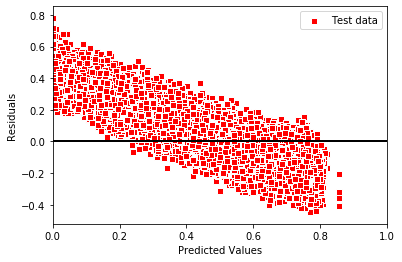

In [368]:
resids(ys2_test, sklm_pred)

In [363]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 1)
lasso.fit(s2_train, ys2_train)

lasso_pred = lasso.predict(s2_test)

scores = cross_val_score(lasso, s2_train, ys2_train, cv=5)
#print('MSE training: ', ((y_pred_train - ys2_train)**2).mean())
print('MSE test: ', ((lasso_pred - ys2_test)**2).mean(),
      "CV scores : ", scores)

MSE test:  0.03701759699351634 CV scores :  [-1.43972847e-04 -6.07578152e-07 -2.40759842e-05 -3.60689772e-05
 -5.67328913e-08]


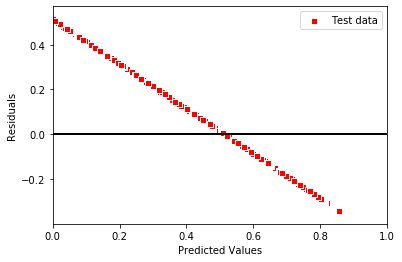

In [369]:
resids(ys2_test, lasso_pred)

In [30]:
#For ease of use, data was saved to CSV files and reloaded
X_train = pd.read_csv('X_train_final.csv')
X_test = pd.read_csv('X_test_final.csv')
y_train = pd.read_csv('y_train.txt', header = None).values.flatten()
y_test = pd.read_csv('y_test.txt', header = None).values.flatten()

In [35]:
from pandas_profiling import ProfileReport
profile = ProfileReport(X_train, minimal=True)

In [37]:
profile.to_widgets()

In [ ]:
profile.to_file(output_file = 'Lab_2_data.html')

In [41]:
from sklearn.ensemble import RandomForestRegressor
RF_reg = RandomForestRegressor(random_state = random_state)

grid_values = {
    'n_estimators': [10, 20],
    'max_depth': [10, 20],
    'max_features':[.25, .15],
    'loss': ['binary_crossentropy', 'categorical_crossentropy'],
    'learning_rate': [.05, .1],
    'min_impurity_decrease':[.01, .05],
    'max_iter': [100, 125],
    'max_leaf_nodes': [41, 51],
    'min_samples_leaf': [10, 20],
    'ccp_alpha':[0,.01],
    'random_state': [random_state]
}

RF_reg = GridSearchCV(RF_reg, param_grid = grid_values)

RF_reg.fit(X_train, y_train)

NameError: name 'GridSearchCV' is not defined